In [1]:
import numpy as np
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(color_codes=True)

In [2]:
import nltk
from collections import Counter

In [6]:
df = pd.read_csv("data/reviews_cleaned.csv", usecols=[1,2,3,4,5,6])
df.drop_duplicates(inplace=True)
df = df[df.rating.notna()]
df.rating = df.rating.astype(int)
df.text = df.text.fillna("")
df.plus = df.plus.fillna("")
df.minus = df.minus.fillna("")

In [7]:
df

,text,plus,minus,language,rating,category
0,,хороший фен свой деньги очень приятный цвет,,russian,5,beauty
1,отличный большой фен,четко,нет негатив,russian,5,beauty
2,,мощный самый главный,тонкий шнур,russian,5,beauty
3,отличный машинка,,,russian,5,beauty
4,,фен понравиться пользоваться недолго существен...,,russian,4,beauty
...,...,...,...,...,...,...
169761,,сказать батарея смело держать заряд день,,russian,5,wearables
169762,,шагомер пульсометр,быстро разряжаться батарея,russian,3,wearables
169763,,очень хорошые часы братишка понравиться работа...,,russian,5,wearables
169764,классный мама купить,,,russian,5,wearables


In [8]:
STOPWORDS = {'и', 'в', 'во', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все',
             'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы',
             'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'о', 'из',
             'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже',
             'или', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж',
             'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они',
             'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем',
             'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе',
             'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого',
             'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем',
             'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда',
             'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над',
             'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая',
             'много', 'разве', 'три', 'эту', 'моя', 'впрочем', 'хорошо', 'свою', 'этой',
             'перед', 'иногда', 'лучше', 'чуть', 'том', 'нельзя', 'такой', 'им',
             'более', 'всегда', 'конечно', 'всю', 'между', 'пока', 'это', 'хотя', 'не', 'нет', 'ни'}
PUNCTUATION = {'$', '=', '_', '?', ')', '*', '[', '(', '{', "'", '\\', ',', ':', ';',
               '|', '+', '`', '.', '<', '@', '%', '#', '"', '^', '&', '>', '}', '~',
               '/', '!', ']', '-', ' ', }


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150025 entries, 0 to 169765
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   text      150025 non-null  object
 1   plus      150025 non-null  object
 2   minus     150025 non-null  object
 3   language  150025 non-null  object
 4   rating    150025 non-null  int32 
 5   category  150025 non-null  object
dtypes: int32(1), object(5)
memory usage: 7.4+ MB


In [10]:
df.rating.describe()

count    150025.000000
mean          4.676034
std           0.844354
min           1.000000
25%           5.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

In [11]:
df.rating.unique()

array([5, 4, 3, 2, 1])

In [12]:
Counter(df.rating)

Counter({5: 123457, 4: 15201, 3: 5046, 2: 1974, 1: 4347})

### Documents initialization

In [13]:
plus_documents = df[df.language == 'russian'].plus
minus_documents = df[df.language == 'russian'].minus
text_documents = df[df.language == 'russian'].text

In [14]:
kaz_plus_documents = df[df.language == 'kazakh'].plus
kaz_minus_documents = df[df.language == 'kazakh'].minus
kaz_text_documents = df[df.language == 'kazakh'].text

## Words Counter

In [15]:
def document_counter(document):
    counter = Counter()
    for review in document:
        for word in review.split():
            if word in STOPWORDS:
                continue
            counter[word] = counter.get(word, 0) + 1
            
    return counter

In [16]:
plus_counts = document_counter(plus_documents)
minus_counts = document_counter(minus_documents)
text_counts = document_counter(text_documents)

In [17]:
kaz_plus_counts = document_counter(kaz_plus_documents)
kaz_minus_counts = document_counter(kaz_minus_documents)
kaz_text_counts = document_counter(kaz_text_documents)

## Bigrams Counter

In [18]:
def bigram_counter(documents):
    bigram_counter = Counter()
    
    for review in documents:
        words = review.split()
        for i, word in enumerate(words):
            if i == 0:
                continue
                
            bigram = f"{words[i-1]} {word}"
            bigram_counter[bigram] = bigram_counter.get(bigram, 0) + 1
    
    return bigram_counter

In [19]:
plus_bigrams = bigram_counter(plus_documents)
minus_bigrams = bigram_counter(minus_documents)
text_bigrams = bigram_counter(text_documents)

In [20]:
kaz_plus_bigrams = bigram_counter(kaz_plus_documents)
kaz_minus_bigrams = bigram_counter(kaz_minus_documents)
kaz_text_bigrams = bigram_counter(kaz_text_documents)

## Visualization

### Positive Comments

In [21]:
bigrams, counts = map(list, zip(*plus_bigrams.most_common(8)))

[Text(0, 0, 'очень понравиться'),
 Text(0, 0, 'очень хороший'),
 Text(0, 0, 'очень удобный'),
 Text(0, 0, 'очень довольный'),
 Text(0, 0, 'цена качество'),
 Text(0, 0, 'спасибо каспи'),
 Text(0, 0, 'хороший телефон'),
 Text(0, 0, 'свой деньги')]

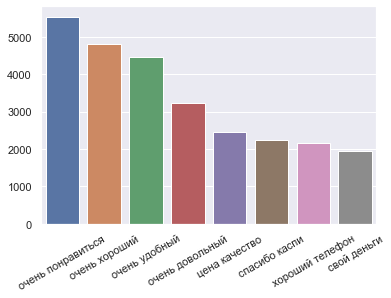

In [22]:
top_words = sns.barplot(x=bigrams, y=counts)
top_words.set_xticklabels(bigrams, rotation=30)

In [30]:
bigrams, counts = map(list, zip(*kaz_plus_bigrams.most_common(8)))

[Text(0, 0, 'өте жақсы'),
 Text(0, 0, 'маған ұнады'),
 Text(0, 0, 'өте керемет'),
 Text(0, 0, 'қатты ұнады'),
 Text(0, 0, 'жақсы телефон'),
 Text(0, 0, 'өте ыңғайлы'),
 Text(0, 0, 'бәрі жақсы'),
 Text(0, 0, 'сапас жақсы')]

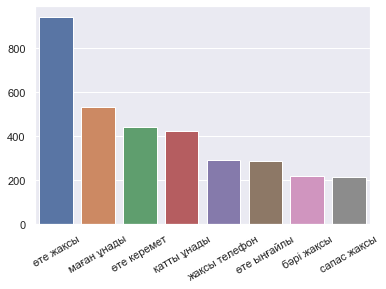

In [31]:
top_words = sns.barplot(x=bigrams, y=counts)
top_words.set_xticklabels(bigrams, rotation=30)

### Negative Comments

In [23]:
bigrams, counts = map(list, zip(*minus_bigrams.most_common(8)))

[Text(0, 0, 'не понравиться'),
 Text(0, 0, 'не очень'),
 Text(0, 0, 'не обнаруживать'),
 Text(0, 0, 'минус нет'),
 Text(0, 0, 'не находить'),
 Text(0, 0, 'недостаток не'),
 Text(0, 0, 'минус не'),
 Text(0, 0, 'не замечать')]

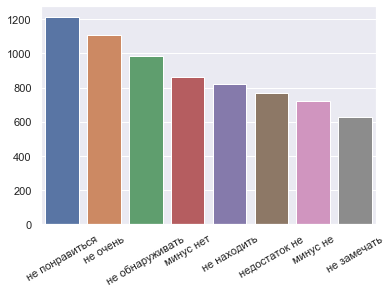

In [24]:
top_words = sns.barplot(x=bigrams, y=counts)
top_words.set_xticklabels(bigrams, rotation=30)

In [ ]:
bigrams, counts = map(list, zip(*kaz_minus_bigrams.most_common(8)))

### Comments

In [25]:
bigrams, counts = map(list, zip(*text_bigrams.most_common(8)))

[Text(0, 0, 'спасибо каспи'),
 Text(0, 0, 'очень понравиться'),
 Text(0, 0, 'очень хороший'),
 Text(0, 0, 'очень довольный'),
 Text(0, 0, 'не пожалеть'),
 Text(0, 0, 'свой деньги'),
 Text(0, 0, 'каспи магазин'),
 Text(0, 0, 'хороший телефон')]

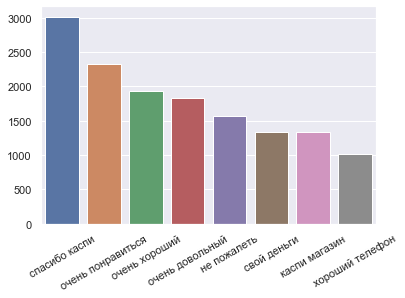

In [26]:
top_words = sns.barplot(x=bigrams, y=counts)
top_words.set_xticklabels(bigrams, rotation=30)

### Ratings

In [27]:
ratings, counts = map(list, zip(*Counter(df.rating).items()))

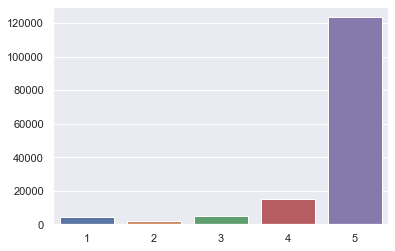

In [28]:
sns.barplot(x=ratings, y=counts)

### Ratings without 5

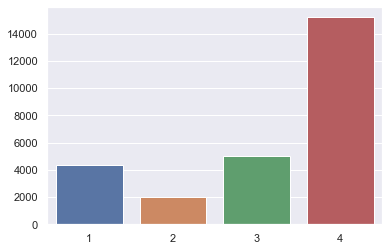

In [29]:
sns.barplot(x=ratings[1:], y=counts[1:])